In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import re
from statsmodels.formula.api import ols
from scipy import stats

In [14]:
df = pd.read_csv('wtest.csv') # ktest.csv for conformity

### Clean data

In [15]:
def strtolistc(val):
    """Convert string to list of floats"""
    ls = val.strip('[] ').split(',')
    new = []
    for v in ls:
        new.append(float(v))
    return(np.array(new))
def strtolist(val):
    """Convert string to list of floats"""
    ls = val.strip('[] ').split(' ')
    ls = [i.strip(',') for i in ls if i != '']
    new = []
    for v in ls:
        new.append(float(v))
    return(np.array(new))
def strtolists(val):
    """Convert string to list of floats"""
    ls = val.strip('[] ').split(', ')
    new = []
    for v in ls:
        new.append(v.strip('"" '))
    return(new)

In [16]:
df['alphaA'] = df['alphaA'].apply(strtolist)
df['betaA'] = df['betaA'].apply(strtolist)
df['alphaB'] = df['alphaB'].apply(strtolist)
df['betaB'] = df['betaB'].apply(strtolist)
df['choices'] = df['choices'].apply(strtolists)

In [17]:
"""Credence/expected bias for each coin"""
df['EA'] = df['alphaA']/(df['alphaA'] + df['betaA'])
df['EB'] = df['alphaB']/(df['alphaB'] + df['betaB'])

In [18]:
"""Whether agents correctly judge coin B as having higher expected payoff"""
df['correct'] = df['EB'] - df['EA']
df['correct'] = df['correct'].map(lambda x: np.where(x > 0, 1, 0))

In [19]:
"""Brier score for each coin bias estimation"""
df['BrierA'] = (df['EA'] - 0.5)**2
df['BrierB'] = (df['EB'] - (0.5 + df['epsilon']))**2

In [20]:
"""Group performance"""
df['true_converg'] = df['correct'].map(lambda x: sum(x)) # Number of successful individuals
df['avgBrierA'] = df['BrierA'].map(lambda x: sum(x)/len(x))
df['avgBrierB'] = df['BrierB'].map(lambda x: sum(x)/len(x))
df['avgBrier'] = (df['avgBrierA'] + df['avgBrierB'])/2 # Average Brier of the group

In [21]:
df['B'] = df['choices'].map(lambda x: x.count("'B'"))

In [22]:
n_all = 10
W = [0.005, 0.0125, 0.1, 0.5, 1]
K = [0, 0.00625, 0.0125, 0.025, 0.05, 0.1]
Div = [0.5, 0.7, 0.9, 1]
df['success'] = (df['B']==n_all)

#### Summary statistics

In [23]:
cols = ['k', 'w', 'div', 'success']
summary = pd.DataFrame(columns=cols) # Summary of convergence rates (based on credences)

for k in K:
    for w in W:
        for div in Div:
            sub = df[((df['k']==k)&(df['w']==w))&(df['div']==div)]['success']
            if len(sub) > 0:
                l = len(sub)
                summary = summary.append(pd.DataFrame([[k, w, div, 
                                                        np.sum(sub)/l]], 
                                                      columns=cols), ignore_index=True)

#### 2(a) in F&S (for 10 agents per group)

In [121]:
summary[(summary['k']==0)&(summary['div']==0.5)]

,k,w,div,success
0,0,0.0050,0.5,0.5563
2,0,0.0125,0.5,0.7191
4,0,0.1000,0.5,0.7962
6,0,0.5000,0.5,0.6855
8,0,1.0000,0.5,0.6296


#### 2(b) in F&S (data: wtest.csv)

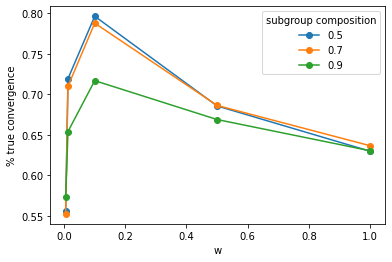

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
k = 0
e = 0.001
Div = [0.5, 0.7, 0.9]

for d in Div:
    sub = summary[(summary['div']==d)&(summary['k']==k)]
    data = list(sub['success'])
    ax.plot(W, data, label=d, marker='o')
plt.xlabel('w')
plt.ylabel('% true convergence')
plt.legend(title='subgroup composition')

# plt.savefig('distrust.png', dpi=300)

#### 4(a) in F&S (data: ktest.csv)

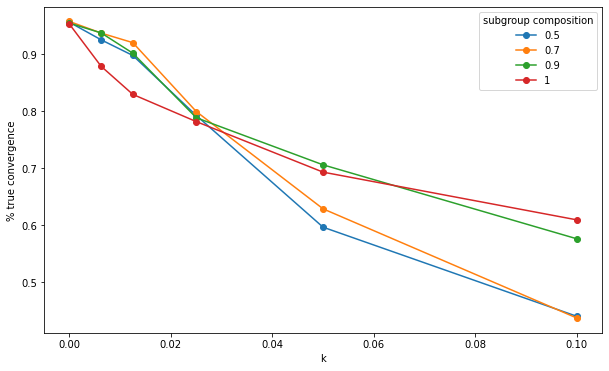

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
w = 1

for d in Div:
    sub = summary[(summary['div']==d)&(summary['w']==w)]
    data = list(sub['success'])
    ax.plot(K, data, label=d, marker='o')
plt.xlabel('k')
plt.ylabel('% true convergence')
plt.legend(title='subgroup composition')

# plt.savefig('conformity.png', dpi=300)